In [1]:
import pandas as pd
import sqlite3
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from hockey_rink import IIHFRink
from shapely.geometry import Polygon 


from scipy.spatial import Voronoi, voronoi_plot_2d

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
# Data Directory
data_dir = "../../Data/Big-Data-Cup-2021"
bucketless_data_dir = '../../Data/bdc/data'
tracking_data_dir = "{}/TrackingData".format(data_dir)
db_path = '/Users/keltim01/Documents/databases/'

#connect to database 
conn = sqlite3.connect(db_path + 'bdc_2022.db')
cursor = conn.cursor()

In [3]:
df_pbp_pp = pd.read_sql('SELECT * FROM play_by_play WHERE frame_id_1 IS NOT NULL AND strength_state > 0', conn) 

In [4]:
# Merging Tracking and Play-by-Play data 
df_tracking = pd.read_sql('SELECT * FROM tracking', conn)

In [5]:
df_pbp_pp['x_coord_adj'] = df_pbp_pp['x_coord'].apply(lambda x: x-100)
df_pbp_pp['y_coord_adj'] = df_pbp_pp['y_coord'].apply(lambda x: x-42.5)
df_pbp_pp['x_end_coord_adj'] = df_pbp_pp['x_coord_2'].apply(lambda x: x-100)
df_pbp_pp['y_end_coord_adj'] = df_pbp_pp['y_coord_2'].apply(lambda x: x-42.5)

In [6]:
df_tracking['x_coord_adj'] = df_tracking['x_coord'].apply(lambda x: x-100)
df_tracking['y_coord_adj'] = df_tracking['y_coord'].apply(lambda x: x-42.5)

In [7]:
df_distance = pd.DataFrame(index=df_pbp_pp.index)
dfs_distance = []
for index in df_pbp_pp.index:
    test_pbp = df_pbp_pp.loc[index]
    test_pbp_next = df_pbp_pp.loc[index]
    test_tracking = df_tracking[(df_tracking['frame_id'] == test_pbp['frame_id_1']) & (df_tracking['game_id'] == test_pbp['game_id']) & (df_tracking['period'] == test_pbp['period'])]
    if (test_pbp['player_name'] in test_tracking['player'].to_list()):
        diff_x1 = test_tracking.loc[(test_tracking['player'] != test_pbp['player_name']) & (test_tracking['venue'] != test_pbp['venue']),'x_coord'] - test_tracking.loc[test_tracking['player'] == test_pbp['player_name'],'x_coord'].values[0]
        diff_x1 = diff_x1.astype(float)
        diff_y1 = abs(test_tracking.loc[(test_tracking['player'] != test_pbp['player_name']) & (test_tracking['venue'] != test_pbp['venue']),'y_coord'] - test_tracking.loc[test_tracking['player'] == test_pbp['player_name'],'y_coord'].values[0])
        pl_distance = np.sqrt(diff_x1**2 + diff_y1**2)
        dfs_distance.append(pl_distance.min())
    else:
        if (test_tracking.size > 0): 
            diff_x1 = test_tracking.loc[(test_tracking['player'] != test_pbp['player_name']) & (test_tracking['venue'] != test_pbp['venue']),'x_coord'] - test_pbp['x_coord']
            diff_x1 = diff_x1.astype(float)
            diff_y1 = abs(test_tracking.loc[(test_tracking['player'] != test_pbp['player_name']) & (test_tracking['venue'] != test_pbp['venue']),'y_coord'] - test_pbp['y_coord'])
            pl_distance = np.sqrt(diff_x1**2 + diff_y1**2)
            dfs_distance.append(pl_distance.min())
        else: 
            dfs_distance.append(np.nan)
    

In [8]:
len(dfs_distance)

861

In [9]:
df_pbp_pp['nearest_defender'] = dfs_distance

In [10]:
df_positions = pd.DataFrame(columns=['game_id','period','frame_id','team_name','player','x_coord','y_coord','venue'])
df_distance_to_avg = pd.DataFrame(index=df_pbp_pp.index)

for index in df_pbp_pp.index:
    test_pbp = df_pbp_pp.loc[index]
    test_tracking = df_tracking[
        (df_tracking['frame_id'] == test_pbp['frame_id_1']) & 
        (df_tracking['game_id'] == test_pbp['game_id']) & 
        (df_tracking['period'] == test_pbp['period']) & 
        (df_tracking['venue'] == test_pbp['venue'])
    ]
    df_positions = pd.concat([df_positions,test_tracking[['game_id','period','frame_id','team_name','player','x_coord','y_coord','venue']]])



In [11]:
df_positions.shape

(4908, 8)

In [12]:
df_positions[df_positions['frame_id']==2062]

,game_id,period,frame_id,team_name,player,x_coord,y_coord,venue
499666,0,1,2062,Switzerland,Nicole Vallario,134.685276,23.150990,away
499667,0,1,2062,Switzerland,Rahel Enzler,120.093170,35.527584,away
499669,0,1,2062,Switzerland,Lara Christen,146.650222,56.618526,away
499670,0,1,2062,Switzerland,Dominique Ruegg,111.323152,67.359344,away
519689,0,1,2062,Switzerland,Phoebe Staenz,16.752410,49.352073,away


In [13]:
df_tracking_test = df_tracking.loc[(df_tracking['frame_id']==96) & (df_tracking['period']==1) & (df_tracking['game_id']==4), :].copy()

In [73]:
def calculate_voronoi(dfTemp):
  values = np.vstack((dfTemp[['x_coord_adj','y_coord_adj']].values,
                      [10,-42.5],
                      [10,+42.5],
                      [130,-42.5],
                      [130,42.5],
                      [10,0],
                      [130,0],
                      ))
  vor = Voronoi(values)

  dfTemp['region'] = vor.point_region[:-6]

  return vor, dfTemp

In [74]:
vor, df_tracking_test = calculate_voronoi(df_tracking_test)

In [75]:
for index, region in enumerate(vor.regions):
    polygon = Polygon([vor.vertices[i] for i in region])
    pl = df_tracking_test.loc[df_tracking_test['region']==index]
    df_tracking_test.loc[df_tracking_test['region']==index,'area'] = polygon.area


In [76]:
df_tracking_test

,index,frame_id,period,track_id,team_id,team_name,jersey_number,x_coord,y_coord,video_shot,game_seconds,venue,player,position,game_id,x_coord_adj,y_coord_adj,region,area
0,0,96,1,2,Light,ROC,100,176.651307,52.308133,1,2590,away,None,None,4,76.651307,9.808133,17,1698.965885
1,1,96,1,3,Light,ROC,27,158.782222,41.325801,1,2590,away,Veronika Korzhakova,Center,4,58.782222,-1.174199,16,1476.413036
2,2,96,1,4,Dark,Finland,10,151.138502,51.883526,1,2590,home,Elisa Holopainen,Left Wing,4,51.138502,9.383526,12,312.640948
3,3,96,1,5,Light,ROC,100,163.814533,59.253376,1,2590,away,None,None,4,63.814533,16.753376,11,1067.100794
4,4,96,1,8,Dark,Finland,88,165.000000,50.000000,1,2590,home,Ronja Savolainen,Defense,4,65.000000,7.500000,15,79.319865
5,5,96,1,6,Light,ROC,100,163.000000,48.000000,1,2590,away,None,None,4,63.000000,5.500000,13,75.799105
6,6,96,1,7,Dark,Finland,24,159.000000,53.000000,1,2590,home,Viivi Vainikka,Center,4,59.000000,10.500000,14,73.699687
7,7,96,1,9,Dark,Finland,9,126.500000,34.100000,1,2590,home,Nelli Laitinen,Defense,4,26.500000,-8.400000,10,1064.732459
8,8,96,1,23,Dark,Finland,15,135.000000,62.000000,1,2590,home,Minnamari Tuominen,Defense,4,35.000000,19.500000,9,1037.890259


In [77]:
direction = -1
def draw_voronoi(dfFrame):
  vor, dfVor = calculate_voronoi(dfFrame)
  for index, region in enumerate(vor.regions): 
      if not -1 in region: 
          if len(region)>0: 
            try: 
              pl = dfVor.loc[dfVor['region']==index]
              polygon = Polygon([vor.vertices[i] for i in region])
              if pl['venue'].values[0]=='home':
                color = 'b'
              else:
                color = 'r'
              x,y = polygon.exterior.xy
              plt.fill(x,y, c=color , alpha=0.2)
            except IndexError:
              pass
            except AttributeError: 
              pass
  return fig, ax, dfFrame

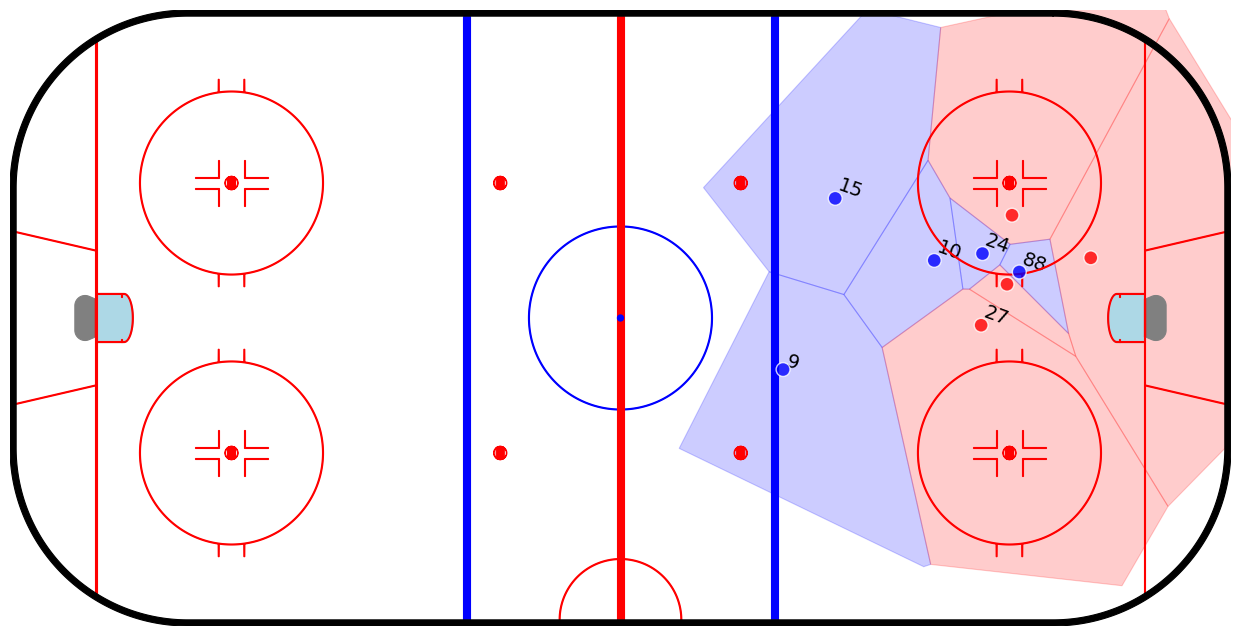

In [78]:
rink = IIHFRink()

fig, ax = plt.subplots(figsize=(18, 8))

text_color = "black"
background = "white"
edge = "white"
sns.set_context("paper")
#fig.text(0.15,0.9,'net expected Threat: {}, lane crossing blue line: {} ,lane exit location: {}'.format(round(plot_xT_net,4), plot_exit_lane_int, plot_exit_lane_loc), fontweight='regular',fontsize=18,color=text_color)


rink.plot_fn(sns.scatterplot, x="x_coord_adj", y="y_coord_adj", s=100, legend=False, data=df_tracking_test, ax=ax, hue='venue', palette=['red','blue'], edgecolor=edge, linewidth=1, alpha=0.8)
for i,row in df_tracking_test.iterrows():
    if row['jersey_number'] != 100:
        ax.annotate(row['jersey_number'], xy=(row['x_coord_adj'], row['y_coord_adj']), size=14, rotation=-20)
draw_voronoi(df_tracking_test)

plt.show()

fig.savefig('figs/voronoi_test.png', dpi=300, bbox_inches='tight')


## Calculate all the areas for all the unique frames

In [82]:
df_tracking['frame_id_unique'] =  df_tracking['frame_id'].astype(str) + '_' + df_tracking['period'].astype(str) + '_' + df_tracking['game_id'].astype(str)

In [84]:
df_tracking['area'] = np.nan
for id in tqdm(df_tracking['frame_id_unique'].unique()):
    _df = df_tracking.loc[df_tracking['frame_id_unique']==id, :].copy()
    _vor, _df = calculate_voronoi(_df)
    if len(region)>0:
        try:
            for index, region in enumerate(_vor.regions):
                _polygon = Polygon([_vor.vertices[i] for i in region])
                _df.loc[_df['region']==index, 'area'] = _polygon.area
        except IndexError:
            pass
        except AttributeError:
            pass
        except ValueError:
            pass
    df_tracking.loc[df_tracking['frame_id_unique']==id, 'area'] = _df['area'].values


100%|██████████| 56905/56905 [52:23<00:00, 18.10it/s]  


In [85]:
df_tracking['area'].describe()


count    2.315700e+04
mean     2.176944e+03
std      3.643041e+04
min      1.094067e-01
25%      3.322052e+02
50%      7.037779e+02
75%      1.239852e+03
max      3.109543e+06
Name: area, dtype: float64

In [86]:
df_tracking.shape

(570274, 19)

In [ ]:
df_tracking.to_sql('tracking', conn, if_exists='replace')

570274